In [12]:
import pandas as pd

df_points = pd.read_csv('../data/final_nosplit_df_points_18_21_class.csv')

In [13]:
df_points = df_points[(df_points['lat'] != 0)]

In [10]:
df_points = df_points[(df_points['idle_time'] > 10)]

,bike_id,lat,lng,dt_start,dt_end,hex_id,hex_enc,in_zone,zone_name,zone_name_enc,...,wind_speed,humidity,year,month,day,start_min,over_night,idle_time_next_day,idle_time,idle_time_class
16,2487,51.324645,12.311425,1514777237,1,881f1a8d9dfffff,326,0,0,0,...,4.60,76.0,2018,1,0,207,NaN,NaN,3,1
44,2156,51.345123,12.357350,1514815777,1,881f1a8cabfffff,275,1,Pinke Zone Leipzig Ost 1€,3,...,9.30,65.0,2018,1,0,850,NaN,NaN,2,1
76,41845,51.343076,12.365177,1514875109,1,881f1a8cbdfffff,283,1,Pinke Zone Leipzig Ost 1€,3,...,7.20,93.0,2018,1,1,398,NaN,NaN,7,1
99,10689,51.340438,12.366765,1514898810,1,881f1a8cb5fffff,279,1,Pinke Zone Leipzig Ost 1€,3,...,8.20,86.0,2018,1,1,794,NaN,NaN,2,1
129,42199,51.340895,12.385023,1514912446,1,881f1a8cb7fffff,280,1,Pinke Zone Leipzig Ost 1€,3,...,7.20,86.0,2018,1,1,1021,NaN,NaN,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781272,72334,51.318182,12.373519,1640883581,1,881f1a1647fffff,125,1,Blaue Zone Leipzig Ost 0€,1,...,5.81,87.0,2021,12,3,1020,NaN,NaN,5,1
1781284,97566,51.344778,12.322033,1640884198,1,881f1a8ddbfffff,352,1,Blaue Zone Leipzig West 0€,2,...,0.89,84.0,2021,12,3,1030,NaN,NaN,6,1
1781315,75851,51.341089,12.367643,1640887381,1,881f1a8cb5fffff,279,1,Pinke Zone Leipzig Ost 1€,3,...,9.39,85.0,2021,12,3,1083,NaN,NaN,2,1
1781327,93653,51.336653,12.335744,1640888495,1,881f1a8ca5fffff,272,1,Blaue Zone Leipzig West 0€,2,...,9.39,85.0,2021,12,3,1102,NaN,NaN,1,1


In [14]:
def f(row):
    if row['idle_time'] < 1440:
        val = '1day'
    elif row['idle_time'] < 2880:
        val = '2day'
    elif row['idle_time'] < 10080:
        val = '1week'
    else:
        val = 'longer'
    return val

df_points['idle_time_class'] = df_points.apply(f, axis=1)

array([1662549,   69092,   39032,    3979])

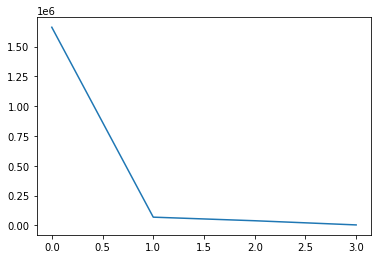

In [31]:
from matplotlib import pyplot as plt

fig = plt.plot(df_points.value_counts(['idle_time_class']).values)
df_points.value_counts(['idle_time_class']).values

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import wandb

#idle_time_data = pd.read_csv('../data/final_nosplit_df_points_18_21_class.csv')

idle_time_data = df_points

TargetVariable = ['idle_time_class']
Predictors = ['bike_id', 'lat', 'lng', 'temp', 'rain', 'snow', 'wind_speed', 'humidity', 'dt_start',
              'hex_enc', 'start_min', 'year', 'month', 'day', 'on_station', 'in_zone', 'zone_name_enc']

X = idle_time_data[Predictors].values
y = idle_time_data[TargetVariable].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [34]:
model = RandomForestClassifier(n_jobs=2,n_estimators=128)

In [35]:
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)

In [36]:
from sklearn.metrics import f1_score


def eval_classification(y_test,y_pred,labels):
    # Metrics
    # Accuracy, precision, recall
    acc = accuracy_score(y_test, y_pred.ravel())
    macro_precision = precision_score(y_test.ravel(), y_pred.ravel(), average='macro', labels=labels)
    micro_precision = precision_score(y_test.ravel(), y_pred.ravel(), average='micro', labels=labels)
    macro_recall = recall_score(y_test.ravel(), y_pred.ravel(), average='macro', labels=labels)
    micro_recall = recall_score(y_test.ravel(), y_pred.ravel(), average='micro', labels=labels)

    macro_f1 = f1_score(y_test.ravel(), y_pred.ravel(), average='macro', labels=labels)
    micro_f1 = f1_score(y_test.ravel(), y_pred.ravel(), average='micro', labels=labels)

    print(acc)
    print(macro_precision, micro_precision)
    print(macro_recall,micro_recall)
    print(macro_f1,micro_f1)

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
accuracy_score(y_test,y_pred)

eval_classification(y_test,y_pred,[1,2,3,4])

print(classification_report(y_test,y_pred))

[[341114     61     41      2]
 [  4422     15      6      3]
 [  8879     17      9      1]
 [   358      3      0      0]]


/usr/local/Caskroom/miniconda/base/envs/geobike/lib/python3.9/site-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/Caskroom/miniconda/base/envs/geobike/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniconda/base/envs/geobike/lib/python3.9/site-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/Caskroom/miniconda/base/envs/geobike/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-d

0.9611389255939887
0.0 0.0
0.0 0.0
0.0 0.0
              precision    recall  f1-score   support

        1day       0.96      1.00      0.98    341218
       1week       0.16      0.00      0.01      4446
        2day       0.16      0.00      0.00      8906
      longer       0.00      0.00      0.00       361

    accuracy                           0.96    354931
   macro avg       0.32      0.25      0.25    354931
weighted avg       0.93      0.96      0.94    354931

